Model Preparation and Training


In [114]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.applications import MobileNet, DenseNet121
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [79]:
# Load dataset
def load_data(data_dir):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                img = cv2.imread(image_path)
                img = cv2.resize(img, (224, 224))  # Resize for MobileNet and DenseNet
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

data_dir = '../data/processed'  # Replace with your dataset path
X, y = load_data(data_dir)

In [80]:
# Encode labels
label_map = {label: idx for idx, label in enumerate(np.unique(y))}
y_encoded = np.array([label_map[label] for label in y])
y_categorical = to_categorical(y_encoded)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [81]:
# Load MobileNet and DenseNet models
mobilenet_model = MobileNet(weights='imagenet', include_top=False, pooling='avg')
densenet_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg')

C:\Users\mayur\AppData\Local\Temp\ipykernel_10648\1536013595.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNet(weights='imagenet', include_top=False, pooling='avg')


In [82]:
# Function to extract features
def extract_features(model, images):
    features = model.predict(preprocess_input(images))
    return features

In [83]:
# Extract features from training and testing sets
X_train_mobilenet = extract_features(mobilenet_model, X_train)
X_test_mobilenet = extract_features(mobilenet_model, X_test)

X_train_densenet = extract_features(densenet_model, X_train)
X_test_densenet = extract_features(densenet_model, X_test)

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 289ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 987ms/step


In [84]:
# Apply PCA on features
def apply_pca(features, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features

In [110]:
X_train_mobilenet_pca = apply_pca(X_train_mobilenet)
X_test_mobilenet_pca = apply_pca(X_test_mobilenet)

X_train_densenet_pca = apply_pca(X_train_densenet)
X_test_densenet_pca = apply_pca(X_test_densenet)

In [116]:
# Combine features from both models
X_train_combined = np.concatenate((X_train_mobilenet_pca, X_train_densenet_pca), axis=1)
X_test_combined = np.concatenate((X_test_mobilenet_pca, X_test_densenet_pca), axis=1)

In [117]:
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on your training data
datagen.fit(X_train_combined)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (3373, 100)

In [100]:
# Define the ANN model using Input layer
model = Sequential()
model.add(Input(shape=(X_train_combined.shape[1],)))  # Input layer specifying the shape of the input data

model.add(Dense(256, activation='relu'))  # First hidden layer with 256 units
model.add(BatchNormalization())  # Normalize activations
model.add(Dropout(0.3))  # Dropout to prevent overfitting

model.add(Dense(128, activation='relu'))  # Second hidden layer with 128 units
model.add(BatchNormalization())  # Normalize activations
model.add(Dropout(0.3))  # Dropout to prevent overfitting

model.add(Dense(64, activation='relu'))  # Third hidden layer with 64 units
model.add(BatchNormalization())  # Normalize activations
model.add(Dropout(0.3))  # Dropout to prevent overfitting

model.add(Dense(32, activation='relu'))  # Fourth hidden layer with 32 units
model.add(BatchNormalization())  # Normalize activations
model.add(Dropout(0.3))  # Dropout to prevent overfitting

model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Output layer for classification

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [108]:
# Train the model
history = model.fit(X_train_combined, y_train, validation_data=(X_test_combined, y_test),
                    epochs=50, batch_size=32 )  # Increased epochs

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3904 - loss: 1.5405 - val_accuracy: 0.5178 - val_loss: 1.0558
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4654 - loss: 1.3369 - val_accuracy: 0.5462 - val_loss: 0.9735
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5580 - loss: 1.1104 - val_accuracy: 0.5818 - val_loss: 0.9305
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5794 - loss: 1.0704 - val_accuracy: 0.6019 - val_loss: 0.9082
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5864 - loss: 1.0232 - val_accuracy: 0.6209 - val_loss: 0.8868
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6153 - loss: 0.9555 - val_accuracy: 0.6256 - val_loss: 0.8772
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6521 - loss: 0.9004 - val_accuracy: 0.6244 - val_loss: 0.8753
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6557 - loss: 0.8530 - val_accuracy: 0.

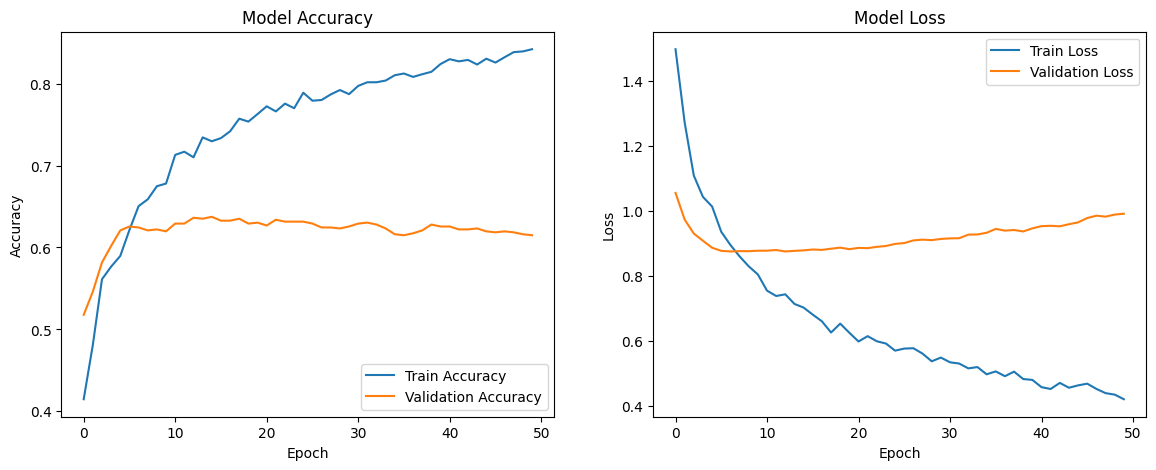

In [109]:
# Plotting training & validation accuracy and loss
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.show()

plot_training_history(history)

In [103]:
# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_combined, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.4335 - loss: 1.2079
Test Accuracy: 0.4479


In [104]:
# Generate classification report
y_pred = model.predict(X_test_combined)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_map.keys())))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.64      0.62      0.63       233
diabetic_retinopathy       0.54      0.67      0.59       224
            glaucoma       0.25      0.37      0.30       188
              normal       0.24      0.08      0.12       199

            accuracy                           0.45       844
           macro avg       0.42      0.43      0.41       844
        weighted avg       0.43      0.45      0.43       844



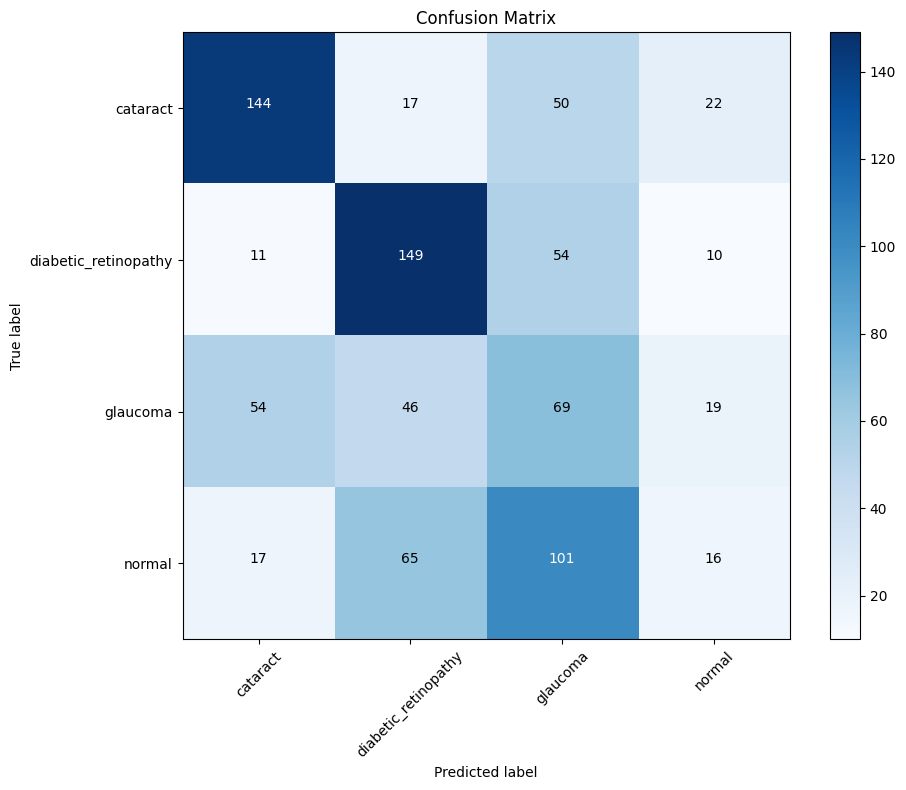

In [105]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_map))
plt.xticks(tick_marks, list(label_map.keys()), rotation=45)
plt.yticks(tick_marks, list(label_map.keys()))

# Add labels
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()